In [1]:
import pickle

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split

from xgboost import XGBClassifier
from pprint import pprint

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# loading already saved features
train = pickle.load(open("dumps/trainFeatures06-02.p", "rb" ))
col = [c for c in train.columns if c[:2]=='z_']
#pprint(col)
columnOld = ['z_AV_word_len1', 'z_AV_word_len2', 'z_STD_word_len1', 'z_STD_word_len2', 'z_noun_match',
             'z_noun_match_ratio', 'z_sequence_match', 'z_word_match_ratio', 'z_tfidf_sum1', 'z_tfidf_sum2',
             'z_caps_count_q1', 'z_caps_count_q2', 'z_diff_caps', 'z_when', 'z_who', 'z_if', 'z_with',
             'z_which', 'z_whi', 'z_how', 'z_what', 'z_special_char_match', 'z_special_char_count',
             'z_shared2grams', 'z_length2grams', 'z_shared3grams', 'z_length3grams',
             'z_q1_hash', 'z_q2_hash', 'z_intersection_count']

In [3]:
temp = pickle.load(open("../data/XandytrainForum158cleaned.p","rb"))
trainAdd = temp[0]
labels = temp[1]



In [4]:
trainNer = pickle.load(open("dumps/trainFeatures_ner_06-02.p", "rb" ))
colner = [c for c in trainNer.columns if c[:5]=='z_ner']

In [5]:
######### FIRST split train/valid set and train: 
trainFeatures = np.concatenate([train[columnOld].values,trainAdd.values,trainNer[colner].values],axis=1)
feature_names = columnOld + trainAdd.columns.values.tolist() + colner
trainFeatures.shape

(404290, 80)

In [6]:
pickle.dump([trainFeatures,labels],open("../finalXandY.p","wb"))

In [8]:
def upSample(X,y):
    npos = np.sum(y)
    negwanted = int(npos/0.165)
    neg = X[y == 0].copy()
    pos = X[y == 1].copy()
    upsampled = np.concatenate([neg,neg,neg,neg[:negwanted-(3*neg.shape[0])],pos])
    labels = [0]*negwanted + [1]*npos
    return upsampled,labels

X,y = upSample(trainFeatures,labels)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
Dtrain = xgb.DMatrix(X_train,y_train,feature_names=feature_names)
Dvalid = xgb.DMatrix(X_test,y_test,feature_names=feature_names) 
params = {}

params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 7
params['subsample'] = 0.6
params['nthread'] = 8
params['colsample_bytree'] = 0.6

watchlist = [(Dtrain,"train"),(Dvalid,"valid")]
bst = xgb.train(params, Dtrain, 1001, evals=watchlist, early_stopping_rounds=10, verbose_eval=50)

[0]	train-logloss:0.6779	valid-logloss:0.677907
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[50]	train-logloss:0.318953	valid-logloss:0.319459
[100]	train-logloss:0.221457	valid-logloss:0.222545
[150]	train-logloss:0.1891	valid-logloss:0.190747
[200]	train-logloss:0.176134	valid-logloss:0.178325
[250]	train-logloss:0.16943	valid-logloss:0.172134
[300]	train-logloss:0.165217	valid-logloss:0.168431
[350]	train-logloss:0.1617	valid-logloss:0.165495
[400]	train-logloss:0.158656	valid-logloss:0.163078
[450]	train-logloss:0.155943	valid-logloss:0.161035
[500]	train-logloss:0.153609	valid-logloss:0.15935
[550]	train-logloss:0.151407	valid-logloss:0.157762
[600]	train-logloss:0.149552	valid-logloss:0.156542
[650]	train-logloss:0.147794	valid-logloss:0.155412
[700]	train-logloss:0.146188	valid-logloss:0.154436
[750]	train-logloss:0.144648	valid-logloss:0.153555
[800]	train-logloss:0.143249

In [12]:
#maybe continue
pickle.dump(bst,open("../finalbst.p","wb"))
bst2 = xgb.train(params, Dtrain, 1001, evals=watchlist, early_stopping_rounds=10, verbose_eval=50, xgb_model=bst)

[0]	train-logloss:0.138242	valid-logloss:0.149986
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[10]	train-logloss:0.138012	valid-logloss:0.149866
[20]	train-logloss:0.137787	valid-logloss:0.149751
[30]	train-logloss:0.137567	valid-logloss:0.149644
[40]	train-logloss:0.137343	valid-logloss:0.14953
[50]	train-logloss:0.137137	valid-logloss:0.149424
[60]	train-logloss:0.136919	valid-logloss:0.149318
[70]	train-logloss:0.136727	valid-logloss:0.149214
[80]	train-logloss:0.136475	valid-logloss:0.149091
[90]	train-logloss:0.136268	valid-logloss:0.148988
[100]	train-logloss:0.136051	valid-logloss:0.148872
[110]	train-logloss:0.135808	valid-logloss:0.148748
[120]	train-logloss:0.135537	valid-logloss:0.14861
[130]	train-logloss:0.135318	valid-logloss:0.148476
[140]	train-logloss:0.135112	valid-logloss:0.148377
[150]	train-logloss:0.134904	valid-logloss:0.148272
[160]	train-logloss:0.134713	v

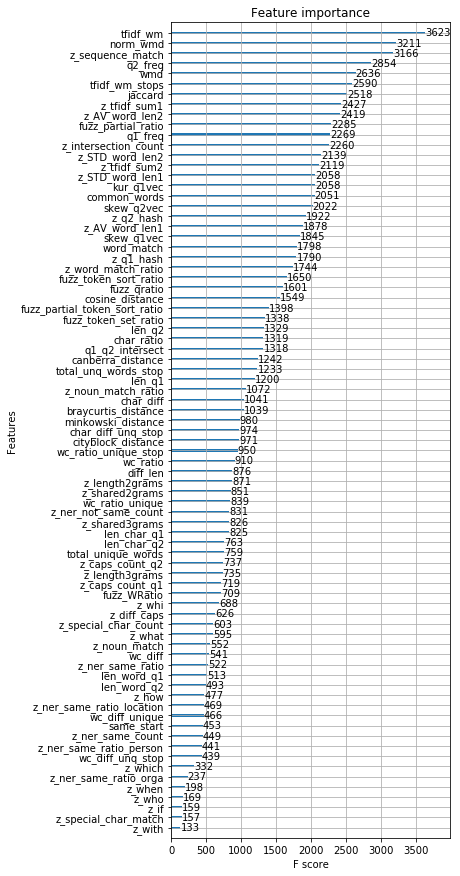

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 15.0)
xgb.plot_importance(bst)
plt.show()

In [11]:
############### TEST feature concat and predict
testAdd = pickle.load(open("../data/XtestForum158cleaned.p","rb"))
test = pickle.load(open("dumps/testFeatures06-02.p", "rb" ))
testNer = pickle.load(open("dumps/testFeatures_ner_06-02.p", "rb" ))
testFeatures = np.concatenate([test[columnOld].values,testAdd.values,testNer[colner].values],axis=1)

pickle.dump(testFeatures,open("../finalTest.p","wb"))
testFeatures.shape

(2345796, 80)

In [15]:
DTest = xgb.DMatrix(testFeatures,feature_names=feature_names)

pickle.dump(bst,open("../finalbst1kiter.p","wb"))

In [16]:
preds = bst.predict(DTest)

test["is_duplicate"] = pd.Series(preds,index=test.index)
header = ["test_id", "is_duplicate"]
test.to_csv('../submissions/predictions.csv', columns = header,index=False)

print("done")

done
